**Tutorial 6 - Regression and parameter estimation on Type Ia Supernovae data**

In this tutorial we will experiment with some type Ia supernova data.  This is part of the data used to determine that Universe's expansion is accelerating.

Data obtained is from the Supernova Cosmology Project at:
http://supernova.lbl.gov/union/descriptions.html#Magvsz

Background:

The observed magnitude of an object with luminosity $L$ is

$m = - 2.5 \log\left( \frac{L}{2\pi D_L^2} \right) + m_o = 5 \log\left( D_L \right) + 2.5 \log\left( L \right) + m_o$

where $D_L$ is the luminosity distance.  The peak luminosity of a type Ia supernovae 
is directly related to the width of its lightcurve and its color.  In this data set, the correction to a standard candle has already been done (we will look at this in a later tutorial) and it is reported in terms of the estimated distance modulus

$\mu = 5 \log\left( D_L \right) - 5$

This assumes a Hubble constant ($D_L \propto 1/H_o$) and requires a calibration using other distance indicators in local galaxies so there is an additive constant to the distance modulus or a multiplicative constant to the brightness that is not very well constrained, ie the relative magnatudes of the supernovae are well measured but not their absolute brightnesses.

General relativity and the energy content of the Universe predicts a function for $D_L(z)$ (or $\mu(z)$) where $z$ is the cosmological redshift of the supernovae.

In this tutorial we will make and test some linear models for $\mu(z)$.  It will be assumed that the measured redshifts are very well measured so that thier erros do not need to be taken into account.  (We will also ignore pecular velocities.) We will also see if a flat Universe without a cosmological constant is an adequate fit to the data under some approximations.

1) Import the data using the command. 

`data = pa.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')`

Note that there are comments starting with 
"#" and the seporators are tabs not commas.

Plot the distance modulus vs redshift with error bars.  Label the axes.

     name  redshift   dist_mod  dist_mod_error  prob_low_mass_g
0  1993ah  0.028488  35.346583        0.223906         0.128419
1  1993ag  0.050043  36.682368        0.166829         0.128419
2   1993o  0.052926  36.817691        0.155756         0.128419
3   1993b  0.070086  37.446737        0.158467         0.128419
4  1992bs  0.062668  37.483409        0.156099         0.128419


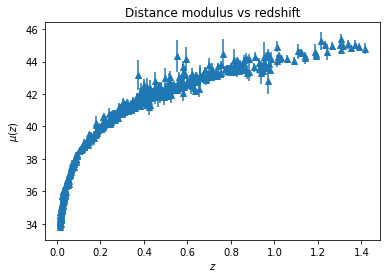

In [1]:
import pandas as pa
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.stats as stat


data = pa.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')
print(data.head())


z = data['redshift']

mu = data['dist_mod']

mu_err = data['dist_mod_error']



_=plt.errorbar(z, mu, marker='^', linestyle='none', yerr=mu_err)
_=plt.xlabel('$z$')
_=plt.ylabel('$\mu(z)$')
_=plt.title('Distance modulus vs redshift')
plt.show()

2) Try fitting these the $\mu(z)$ data with a polynomial models of order 1,2 and 3 in $z$ using numpy.polyfit(). Use the w parameter in this function to include the errors from the data files in these $\chi^2$ fits.  Plot these models on top of the data.  Leave the errors out to improve clarity.  Do these make good models?

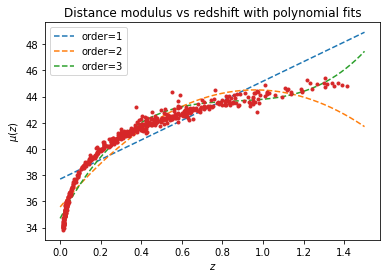

In [2]:
p_1, p_0 = np.polyfit(z, mu, 1, w=mu_err)
q_2, q_1, q_0 = np.polyfit(z, mu, 2, w=mu_err)
r_3, r_2, r_1, r_0 = np.polyfit(z, mu, 3, w=mu_err)

xp = np.linspace(0, 1.5, len(z))
xq = np.linspace(0, 1.5, len(z))
xr = np.linspace(0, 1.5, len(z))

_= plt.plot(xp, p_0 + p_1*xp, linestyle='--', label='order=1')
_= plt.plot(xq, q_0 + q_1*xq + q_2*(xq**2), linestyle='--', label='order=2')
_= plt.plot(xr, r_0 + r_1*xr + r_2*(xr**2) + r_3*(xr**3), linestyle='--', label='order=3')
_= plt.plot(z, mu, marker='.', linestyle='none')

_=plt.xlabel('$z$')
_=plt.ylabel('$\mu(z)$')
_=plt.title('Distance modulus vs redshift with polynomial fits')
plt.legend()
plt.show()

3) Let's try fitting a model to the luminosity distance instead of the distance modulus.  

Convert the distance modulus into luminosity distance
$D_L = A ~10^{\mu/5}$

were we don't know the constant $A$ because of calibration and uncertainties in the Hubble constant.

You can estimate the errors in the distance using the expansion

$ \delta D_L \sim \frac{\ln(10)}{5} ~ D_L \delta \mu$

,the first order expansion of $D_L$ in terms of $\mu$.  This is only an approximation.

We want to fit a second order polynomial to $D_L$ vs $z$ with a zero intercept, i.e. the constant term is zero.  This is because we know that $D_L(z=0)=0$.

numpy.polyfit() does not allow for a zero intercept.  So we will use numpy.linalg.lstsq(M,y) to do the fit.  First you need to construct the M matrix which is of the form
\begin{equation}
M = \left(
\begin{array}{cc}
z_1^2 & z_1 \\
z_2^2 & z_2 \\
\vdots & \vdots \\
z_i^2 & z_i
\end{array}
\right)
\end{equation}
The $y$'s in this case are the $D_L$'s.  Now we need to weight by the errors.  There doesn't seem to be a function for doing this automatically in python, but we can do it ourselves.  If the dependent variables and the columns of the M matrix are divided by the standard deviations this will be equivalent to the chi-squared weighting as described in the lecture notes.

Fit a second order polynomial to $D_L$ vs $z$. Plot it and the data.

0       50
1      148
2      132
3      159
4      139
      ... 
575    557
576    570
577    533
578    537
579    573
Name: redshift, Length: 580, dtype: int64


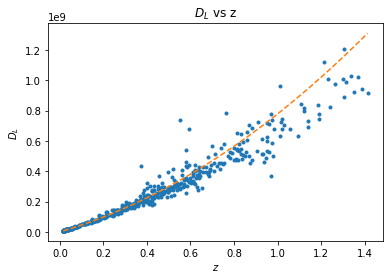

In [2]:
ind = np.argsort(z)
mu = mu[ind]
mu_err = mu_err[ind]

print(ind)

D_L=np.zeros(len(mu))
D_L = 10**(mu/5)

#D_L_sort = np.sort(D_L)
    
D_L_err=np.zeros(len(D_L))
D_L_err = (np.log(10)/5)*D_L*mu_err
    
z_mat = np.zeros((len(z),2))
z_mat[:,0] = np.sort(z)**2
z_mat[:,1] = np.sort(z)

## weighted least squares
def weighted_lstsq(M,y,sigma):
    yw = y/(sigma**2)
    Mw = np.zeros(np.shape(M))
    Mw[:,0] = M[:,0]/(sigma**2)
    Mw[:,1] = M[:,1]/(sigma**2)
    return np.linalg.lstsq(Mw,yw,rcond=None)

p = np.zeros(3)
p[2],p[1]= weighted_lstsq(z_mat, D_L, D_L_err)[0]

_= plt.plot(np.sort(z), D_L, marker='.',linestyle='none')
_= plt.plot(np.sort(z), p[2]*(np.sort(z)**2)+p[1]*(np.sort(z)), linestyle='--')
_= plt.xlabel('$z$')
_= plt.ylabel('$D_L$')
_= plt.title('$D_L$ vs z')

plt.show()


4) General relativity and the standard cosmological model predict that to 
second order

$D_L(z) \simeq \frac{c}{H_o} \left[ z + \frac{z^2}{2}(1-q_o) \right]$

where $q_o$ is called the deceleration parameter which is given by

$q_o = \frac{\Omega_m}{2} - \Omega_\Lambda$

where $\Omega_m$ is the density of the Universe in ordinary matter in units of the critical density and $\Omega_\Lambda$ is the energy density of the cosmological constant in the same units.

If the Universe is geometrically flat $\Omega_m+ \Omega_\Lambda = 1$ and 

$q_o = \frac{3}{2}\Omega_m - 1$

If there is no cosmological constant (the expansion is not accelerating) $q_o=1/2$.

We have found a second order model already.  You can see that $q_o$ is a combination of linear model coefficients. You can also see that $p[0]/p[1] = (1-q_o)/2$ where $p[]$ are the model coefficients.

For a flat universe with no cosmological constant $\Omega_m = 1$, $\Omega_\Lambda =0$  $p[0]/p[1] = 1/4$.  

What is your measured value for $q_o$?  If the universe is flat what is your measured value for $\Omega_m$?

In [4]:
q_0 = 1 - 2*(p[2]/p[1])
print("The measured value for q_0 is: ",str(q_0),"\n")

O_m = (q_0 + 1)*2/3
print("If we assume a flat universe the measured valu for Omega_m is: ",str(O_m),"\n")

The measured value for q_0 is:  -0.7245468694667709 

If we assume a flat universe the measured valu for Omega_m is:  0.18363542035548605 



5) This looks good, but the errors are not really on $D_L$.  They are on 
the distance modulus.  And we don't have an error on $q_o$ because it is a nonlinear combination of linear parameters.

What we really want to find is a nonlinear model.  For this let's use scipy.optimize.curve_fit().  For this we must 

a) Define a function func_modulus($z,\mu_o,q_o$) which returns 

$\mu(z) = 5\log_{10}\left[ z + \frac{1}{2}(1-qo)z^2\right] + \mu_o$


In [4]:
def func_modulus(z,muo,qo):
    mu = 5*np.log10(z + 0.5*(1-qo)*(z**2))+muo
    return mu

b) Use scipy.optimize.curve_fit() to find the best fit model.  Use the sigma and absolute_sigma=True options to include the errors.

The outputs of this function are model,covariance.

What is the $q_o$ you get in this way?

In [5]:

popt, pcov = opt.curve_fit(func_modulus, np.sort(z), mu, sigma=mu_err)

print("The optimized value of q_0 is ", str(popt[1]))

The optimized value of q_0 is  -0.1748101860646313


c) Use func_modulus(z,muo,qo) to plot the best fit model over the data.

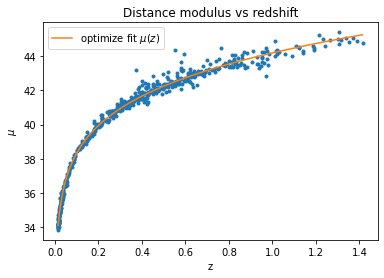

In [6]:
mu_opt = func_modulus(np.sort(z), popt[0], popt[1])

_= plt.plot(np.sort(z), mu, marker='.', linestyle='none')
_= plt.plot(np.sort(z), mu_opt, linestyle='-',label='optimize fit $\mu(z)$')
_= plt.xlabel('z')
_= plt.ylabel('$\mu$')
_= plt.title('Distance modulus vs redshift')

plt.legend()
plt.show()

6) Calculate the $\chi^2$ for this model and data.  Remember that 

$\chi^2 = \sum_i \frac{ [ y_i - model(x_i)~ ]^2}{\sigma^2} $

where $model(x_i)$ is the best fit model.

Is this an acceptable fit?  Use the $\chi^2$ distribution to find out.  Use N-2 degrees of freedom. (hint: Use scipy.stats.chi2.cdf() to find its significance. )

In [7]:
chi = np.sum(abs(mu - func_modulus(np.sort(z),popt[0],popt[1]))**2/(mu_err**2))
print(chi)

dof = len(z) - 2     #N-2 degrees of freedom
p_value = 1 - stat.chi2.cdf(chi, dof)
print(p_value)


581.3901985702616
0.452591193309104


7) Why might a person object to using a $\chi^2_{n-2}$ distribution 
above in determining the significance of the result?

8) Plot the $\chi^2$ p-value with $n$ degrees of freedom as a function of $q_o$ over a range that includes the best fit value and extends to where it is a small fraction of its peak.

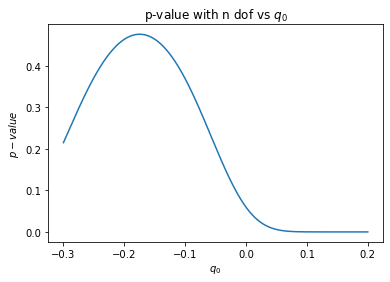

In [8]:
q0 = np.linspace(-0.3, 0.2, len(z))
chi2 = np.zeros(len(z))
p_val = np.zeros(len(z))

for i in range(len(z)):
    MU = func_modulus(np.sort(z), popt[0], q0[i])
    chi2[i] = np.sum(abs(mu - MU)**2/(mu_err**2))
    p_val[i] = 1 - stat.chi2.cdf(chi2[i], len(z))
    
#print(p_val)
    
_ = plt.plot(q0, p_val, linestyle='-')
_ = plt.xlabel('$q_0$')
_ = plt.ylabel('$p-value$')
_ = plt.title('p-value with n dof vs $q_0$')
plt.show()

9) Let's try finding error bars on our measurement of $q_o$ in a different way.

Find the bootstrap variance of your estimate of $q_o$.  This will require you to make a new data sets by sampling from the original one with replacement (Hint: numpy.random.choice(N,N) will give you a random set of integers between 0 and N-1).  Then find $q_o$ from this data set.  Put this in a loop and repeat 1000 times recording the $q_o$ value each time in a vector of $q_o$'s. 

Make a nice histogram of the $q_o$ vector.

This vector of $q_o$'s is approximately sampled from the true distribution.  Find the mean and variance of this vector.  This is an estimate of the variance in the estimate of $q_o$.

What is the measured value of $q_o$ with errors?

Assuming the Universe is flat what is the measured value of $\Omega_m$ with errors?

In [9]:
### put loop here
q_o = np.zeros(1000)

red = data['redshift']
Mu = data['dist_mod']
Mu_err = data['dist_mod_error']

for i in range(1000):
    ind = np.random.choice(len(z), len(z))
    par, cov = opt.curve_fit(func_modulus, red[ind], Mu[ind], sigma = Mu_err[ind], absolute_sigma=True)
    q_o[i]=par[1]


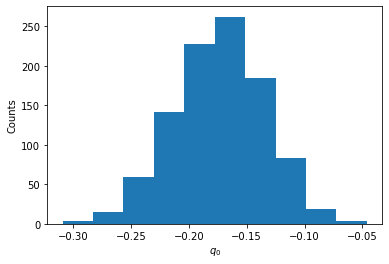

Bootstrap sampling $q_0$ mean -0.17359219899552267
Bootstrap sampling $\Omega_m$ mean 0.5509385340029849
qo =  -0.1748101860646313  +/-  0.03905754938519085
$Omega_m$ =  0.5501265426235792  +/-  0.03905754938519085


In [12]:
### put plot here
_=plt.hist(q_o)
_=plt.xlabel('$q_0$')
_=plt.ylabel('Counts')
plt.show()

print('Bootstrap sampling $q_0$ mean',str(np.mean(q_o)))
print('Bootstrap sampling $\Omega_m$ mean',str((np.mean(q_o)+1)*2/3))
var_q_o = np.var(q_o)
Om_bootstrap = (popt[1]+1)*2/3

print('qo = ', popt[1] ,' +/- ', np.sqrt(var_q_o))
print('$Omega_m$ = ', Om_bootstrap ,' +/- ', np.sqrt(var_q_o) )


Comment:  In this tutorial we have made several approximations that might not be justified.  One is that we use an expansion for $D_L$ as a function of $z$ that is not really valid at z ~ 1.  If we use the correct relationship and calculate the errors in a better way we might get a different answer for $\Omega_m$.  Also we have assumed the Universe geometricly flat.  We will do better in a future tutorial!